In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from tqdm import tqdm
from glob import glob
import os
import json 
import timm
import torch
from torch import nn
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold
import albumentations as A

In [2]:
village_data = os.listdir('./data/public/PlantVillage')
label_encoder = {}
for idx, data_name in enumerate(village_data) :
    label_encoder[idx] = data_name

label_decoder = {val:key for key, val in label_encoder.items()}
display(label_decoder)
display(label_encoder)

{'Apple___Apple_scab': 0,
 'Apple___Black_rot': 1,
 'Apple___Cedar_apple_rust': 2,
 'Apple___healthy': 3,
 'Blueberry___healthy': 4,
 'Cherry_(including_sour)___healthy': 5,
 'Cherry_(including_sour)___Powdery_mildew': 6,
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7,
 'Corn_(maize)___Common_rust_': 8,
 'Corn_(maize)___healthy': 9,
 'Corn_(maize)___Northern_Leaf_Blight': 10,
 'Grape___Black_rot': 11,
 'Grape___Esca_(Black_Measles)': 12,
 'Grape___healthy': 13,
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 14,
 'Orange___Haunglongbing_(Citrus_greening)': 15,
 'Peach___Bacterial_spot': 16,
 'Peach___healthy': 17,
 'Pepper,_bell___Bacterial_spot': 18,
 'Pepper,_bell___healthy': 19,
 'Potato___Early_blight': 20,
 'Potato___healthy': 21,
 'Potato___Late_blight': 22,
 'Raspberry___healthy': 23,
 'Soybean___healthy': 24,
 'Squash___Powdery_mildew': 25,
 'Strawberry___healthy': 26,
 'Strawberry___Leaf_scorch': 27,
 'Tomato___Bacterial_spot': 28,
 'Tomato___Early_blight': 29,
 'Toma

{0: 'Apple___Apple_scab',
 1: 'Apple___Black_rot',
 2: 'Apple___Cedar_apple_rust',
 3: 'Apple___healthy',
 4: 'Blueberry___healthy',
 5: 'Cherry_(including_sour)___healthy',
 6: 'Cherry_(including_sour)___Powdery_mildew',
 7: 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 8: 'Corn_(maize)___Common_rust_',
 9: 'Corn_(maize)___healthy',
 10: 'Corn_(maize)___Northern_Leaf_Blight',
 11: 'Grape___Black_rot',
 12: 'Grape___Esca_(Black_Measles)',
 13: 'Grape___healthy',
 14: 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 15: 'Orange___Haunglongbing_(Citrus_greening)',
 16: 'Peach___Bacterial_spot',
 17: 'Peach___healthy',
 18: 'Pepper,_bell___Bacterial_spot',
 19: 'Pepper,_bell___healthy',
 20: 'Potato___Early_blight',
 21: 'Potato___healthy',
 22: 'Potato___Late_blight',
 23: 'Raspberry___healthy',
 24: 'Soybean___healthy',
 25: 'Squash___Powdery_mildew',
 26: 'Strawberry___healthy',
 27: 'Strawberry___Leaf_scorch',
 28: 'Tomato___Bacterial_spot',
 29: 'Tomato___Early_blight',
 30: '

# Meas std 계산 => 성능하락
=================
#### 20k
- mean : tensor([0.5528, 0.5525, 0.5522])
- std : tensor([0.1163, 0.1164, 0.1171])

=================
#### 50k
- mean : tensor([0.5577, 0.5577, 0.5576])
- std : tensor([0.1586, 0.1584, 0.1586])

In [3]:
# class SamplingDataset(Dataset) :
#     def __init__(self, files) :
#         super(SamplingDataset, self).__init__()
#         self.files = files
        
#     def __len__(self) :
#         return len(self.files)
    
#     def __getitem__(self, idx) :
#         file_path = self.files[idx]

#         img = cv2.imread(file_path)
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        
#         return torch.tensor(img, dtype=torch.float), torch.tensor(img, dtype=torch.float)

In [4]:
# class Mean_Std() :
#     def __init__ (self, dataloader, img_output_pos=0) :
#         self.mean, self.std = self.get_val(dataloader, pos=img_output_pos)
        
#     def get_val(self, dataloader, pos=0) :
#         RGB_CHANNEL = 3
#         img_mean = torch.zeros(3)
#         img_std = torch.zeros(3)
#         for output in tqdm(dataloader) :
#             for i in range(RGB_CHANNEL):
#                 if not pos is None :
#                     img_mean[i] += output[pos][:, i, :, :].mean()
#                     img_std[i] += output[pos][:, i, :, :].std()
#                 else : 
#                     img_mean[i] += output[:, i, :, :].mean()
#                     img_std[i] += output[:, i, :, :].std()
# #         return img_mean.div(len(dataloader)), img_std.div(len(dataloader))
#         return img_mean.div(len(dataloader)) /255.0, img_std.div(len(dataloader)) /255.0

In [5]:
# transforms = A.Compose([
# #     A.Resize(224, 224),
# #     A.RandomCrop(180, 180),
# #     A.OneOf([
# #         A.HorizontalFlip(p=1),
# #         A.RandomRotate90(p=1),
# #         A.VerticalFlip(p=1)
# #     ],p=1),
# ])

# train = glob('./data/public/PlantVillage/*/*.JPG')
# print("total : ", len(train))
# label_list = [label_decoder[img_path.split('\\')[-2]] for img_path in train]

# sample_dataset = SamplingDataset(train)
# dataloader = DataLoader(sample_dataset, batch_size=32, shuffle=True)

# M_S = Mean_Std(dataloader, 0)
# MM = M_S.mean
# SS = M_S.std

# print(MM)
# print(SS)

In [6]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)
 
    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

In [7]:
import timm

class DeiT(nn.Module):
    def __init__(self, model_name, n_classes):
        super(DeiT, self).__init__()
        self.model = timm.create_model(model_name, num_classes=n_classes, pretrained=True)
    
    def forward(self, inputs):
        output = self.model(inputs)
        return output
    
class EffiV2S(nn.Module):
    def __init__(self, model_name, n_classes):
        super(EffiV2S, self).__init__()
        self.model = timm.create_model(model_name, num_classes=n_classes, pretrained=True)
    
    def forward(self, inputs):
        output = self.model(inputs)
        return output

In [8]:
def accuracy_function(real, pred):    
    real = real.cpu()
    pred = torch.argmax(pred, dim=1).cpu()
    score = f1_score(real, pred, average='macro')
    return score

def train_step(batch_item, training):
    img = batch_item[0].to(device)
    label = batch_item[1].to(device)

    lam = np.random.beta(1.0, 1.0)
    
    if training is True:
        model.train()
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            # add - cutmix
            rand_index = torch.randperm(img.size()[0])
            target_a = label
            target_b = label[rand_index]
            bbx1, bby1, bbx2, bby2 = rand_bbox(img.size(), lam)
            img[:, :, bbx1:bbx2, bby1:bby2] = img[rand_index, :, bbx1:bbx2, bby1:bby2]
            lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (img.size()[-1] * img.size()[-2]))
            
            output = model(img)
            loss = criterion(output, target_a) * lam + criterion(output, target_b) * (1. - lam)
            
#             output = model(img, csv_feature)
#             loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        score = accuracy_function(label, output)
        return loss, score
    else:
        model.eval()
        with torch.no_grad():
            output = model(img)
            loss = criterion(output, label)
        score = accuracy_function(label, output)
        return loss, score

In [9]:
device = torch.device("cuda:0")#("cpu")
batch_size = 16
n_classes = 38
model_name = 'efficientnetv2_rw_s'
learning_rate = 1e-4
epochs = 20
save_path = './model/public_vill_50k_pretrain_efficientnetv2S.pt'

In [10]:
class VillageDataset(Dataset) :
    def __init__(self, files, transform, mode='train') :
        super(VillageDataset, self).__init__()
        self.files = files
        self.transform = transform
        self.mode = mode
        
    def __len__(self) :
        return len(self.files)
    
    def __getitem__(self, idx) :
        file_path = self.files[idx]
        
        label = label_decoder[file_path.split('\\')[-2]]
        
        img = cv2.imread(file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = self.transform(image=img)['image']
        img = img.transpose(2, 0, 1)
        
#         return torch.tensor(img, dtype=torch.float32), torch.tensor(label, dtype=torch.long)
        return torch.tensor(img, dtype=torch.float32) / 255.0, torch.tensor(label, dtype=torch.long)

In [11]:
train_transforms = A.Compose([
                A.Resize(288, 288),
                A.OneOf([
                    A.Rotate(),
                    A.HorizontalFlip(),
                    A.VerticalFlip()
                ], p=1)
            ])

val_transforms = A.Compose([
    A.Resize(288, 288)
])

train = glob('./data/public/PlantVillage/*/*.JPG')
print("total : ", len(train))
label_list = [label_decoder[img_path.split('\\')[-2]] for img_path in train]

train, val = train_test_split(train, test_size=0.2, shuffle=True, stratify=label_list)
print("train : ", len(train))
print("val : ", len(val))

train_dataset = VillageDataset(train, train_transforms)
val_dataset = VillageDataset(val, val_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

total :  54304
train :  43443
val :  10861


In [12]:
model = EffiV2S(model_name, n_classes)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [13]:
loss_plot, val_loss_plot = [], []
metric_plot, val_metric_plot = [], []

early_stopping = 0
for epoch in range(epochs):
    total_loss, total_val_loss = 0, 0
    total_acc, total_val_acc = 0, 0

    tqdm_dataset = tqdm(enumerate(train_loader))
    training = True
    for batch, batch_item in tqdm_dataset:
        batch_loss, batch_acc = train_step(batch_item, training)
        total_loss += batch_loss
        total_acc += batch_acc

        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Loss': '{:06f}'.format(batch_loss.item()),
            'Mean Loss' : '{:06f}'.format(total_loss/(batch+1)),
            'Mean F-1' : '{:06f}'.format(total_acc/(batch+1))
        })
    loss_plot.append(total_loss/(batch+1))
    metric_plot.append(total_acc/(batch+1))

    tqdm_dataset = tqdm(enumerate(val_loader))
    training = False
    for batch, batch_item in tqdm_dataset:
        batch_loss, batch_acc = train_step(batch_item, training)
        total_val_loss += batch_loss
        total_val_acc += batch_acc

        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Val Loss': '{:06f}'.format(batch_loss.item()),
            'Mean Val Loss' : '{:06f}'.format(total_val_loss/(batch+1)),
            'Mean Val F-1' : '{:06f}'.format(total_val_acc/(batch+1))
        })
    val_loss_plot.append(total_val_loss/(batch+1))
    val_metric_plot.append(total_val_acc/(batch+1))
    
    if np.max(val_metric_plot) == val_metric_plot[-1]:
        torch.save(model.state_dict(), f'{save_path}')
        early_stopping = 0
    
    elif np.max(val_metric_plot) > val_metric_plot[-1]: 
        early_stopping += 1
        print(f"Early Stopping Step : [{early_stopping} / 3]")
    
    if early_stopping == 3 :
        print("== Early Stop ==")
        break

2716it [14:01,  3.23it/s, Epoch=1, Loss=0.530942, Mean Loss=1.183911, Mean F-1=0.621989]
679it [01:29,  7.58it/s, Epoch=1, Val Loss=0.083525, Mean Val Loss=0.070497, Mean Val F-1=0.978425]
2716it [14:05,  3.21it/s, Epoch=2, Loss=2.470865, Mean Loss=0.770495, Mean F-1=0.711967]
679it [01:31,  7.44it/s, Epoch=2, Val Loss=0.044201, Mean Val Loss=0.030087, Mean Val F-1=0.988169]
2716it [14:23,  3.14it/s, Epoch=3, Loss=1.895427, Mean Loss=0.687319, Mean F-1=0.730174]
679it [01:40,  6.76it/s, Epoch=3, Val Loss=0.041594, Mean Val Loss=0.024179, Mean Val F-1=0.992870]
2716it [15:10,  2.98it/s, Epoch=4, Loss=1.702116, Mean Loss=0.647484, Mean F-1=0.740465]
679it [01:52,  6.05it/s, Epoch=4, Val Loss=0.007659, Mean Val Loss=0.013330, Mean Val F-1=0.995614]
2716it [15:34,  2.91it/s, Epoch=5, Loss=1.274506, Mean Loss=0.618538, Mean F-1=0.754422]
679it [02:04,  5.47it/s, Epoch=5, Val Loss=0.009502, Mean Val Loss=0.011915, Mean Val F-1=0.993357]


Early Stopping Step : [1 / 3]


2716it [16:20,  2.77it/s, Epoch=6, Loss=1.489624, Mean Loss=0.606256, Mean F-1=0.756928]
679it [02:16,  4.98it/s, Epoch=6, Val Loss=0.021634, Mean Val Loss=0.015595, Mean Val F-1=0.992534]


Early Stopping Step : [2 / 3]


2716it [17:23,  2.60it/s, Epoch=7, Loss=0.984335, Mean Loss=0.596656, Mean F-1=0.743181]
679it [02:33,  4.41it/s, Epoch=7, Val Loss=0.012324, Mean Val Loss=0.049594, Mean Val F-1=0.972365]

Early Stopping Step : [3 / 3]
== Early Stop ==


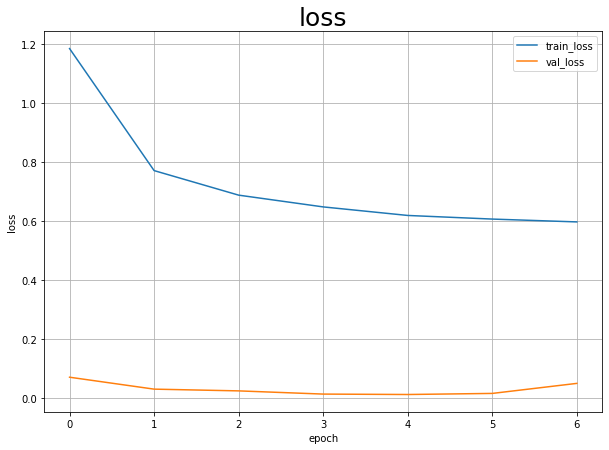

In [14]:
plt.figure(figsize=(10,7))
plt.grid()
plt.plot(loss_plot, label='train_loss')
plt.plot(val_loss_plot, label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss', fontsize=25)
plt.legend()
plt.show()

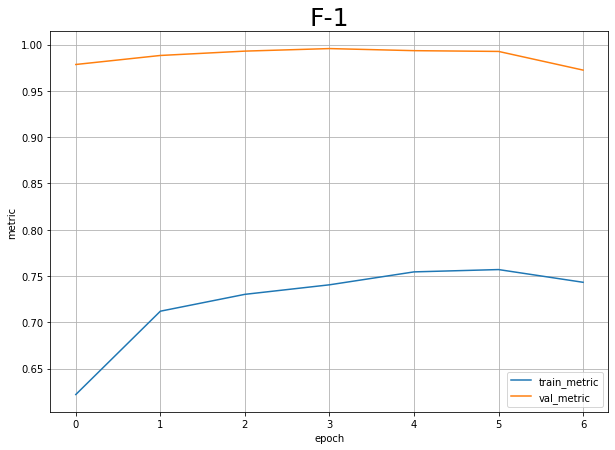

In [15]:
plt.figure(figsize=(10, 7))
plt.grid()
plt.plot(metric_plot, label='train_metric')
plt.plot(val_metric_plot, label='val_metric')
plt.xlabel('epoch')
plt.ylabel('metric')
plt.title("F-1", fontsize=25)
plt.legend()
plt.show()